<a href="https://colab.research.google.com/github/ananyabanka/22BDS0154/blob/main/SpeechEmotionRecognition_MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speech Emotion Recognition ML Model


Phase 1 - Environment Setup

In [1]:
!pip install librosa pandas numpy matplotlib seaborn scikit-learn tqdm kaggle joblib


In [2]:
#Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#Create Project Folder in Drive

In [5]:
!mkdir -p /content/drive/MyDrive/SpeechEmotionRecognition


PHASE 2 — CONNECT TO KAGGLE & DOWNLOAD DATASET

In [6]:
#Install Kaggle & Check Version

In [7]:
!pip install kaggle
!kaggle --version


Kaggle API 1.7.4.5


In [8]:
#Upload Your kaggle.json

In [9]:
from google.colab import files
files.upload()


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ananyabanka","key":"2369a8d49d8ef1decebf46d35dc42e84"}'}

In [10]:
#Move kaggle.json to Config Folder

In [11]:
!mkdir -p ~/.kaggle
!mv "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -la ~/.kaggle


total 16
drwxr-xr-x 2 root root 4096 Nov  7 13:31 .
drwx------ 1 root root 4096 Nov  7 13:31 ..
-rw------- 1 root root   67 Nov  7 13:31 kaggle.json


Phase 3 - Load and Verify Dataset

In [12]:
#Verify Kaggle Login

In [13]:
!kaggle datasets list -s cremad | head


ref                                                       title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayeshlandge/cremad                                       cremad                                           473324524  2024-03-24 13:03:14.537000            201          1  0.1875           
ftaham/multi-source-emotion-dataset                       Merged Emotional Speech (RAVDESS,SAVEE,CREMAD)       45471  2024-11-13 13:48:37.233000             84          3  0.64705884       
sayan3270/cremad                                          CREMAD                                                4103  2024-08-11 17:55:58.477000              5          0  0.25             
biminhco/cremad                                   

In [14]:
#Download the Dataset

In [15]:
!kaggle datasets download -d ejlok1/cremad


Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 91% 412M/451M [00:07<00:00, 68.5MB/s]
100% 451M/451M [00:07<00:00, 60.1MB/s]


In [16]:
#Verify the File

In [17]:
!ls -lh /content


total 452M
-rw-r--r-- 1 root root 452M Aug 30  2019 cremad.zip
drwx------ 5 root root 4.0K Nov  7 13:31 drive
drwxr-xr-x 1 root root 4.0K Nov  5 14:33 sample_data


In [18]:
#Unzip the Dataset

In [19]:
!unzip -q cremad.zip -d CREMA-D


In [20]:
#Verify Extraction

In [21]:
!ls CREMA-D | head


AudioWAV


In [22]:
!ls CREMA-D/AudioWAV | head


1001_DFA_ANG_XX.wav
1001_DFA_DIS_XX.wav
1001_DFA_FEA_XX.wav
1001_DFA_HAP_XX.wav
1001_DFA_NEU_XX.wav
1001_DFA_SAD_XX.wav
1001_IEO_ANG_HI.wav
1001_IEO_ANG_LO.wav
1001_IEO_ANG_MD.wav
1001_IEO_DIS_HI.wav


In [23]:
import os
print("Total files:", len(os.listdir("CREMA-D")))


Total files: 1


In [24]:
import os
print("Total .wav files:", len(os.listdir("CREMA-D/AudioWAV")))


Total .wav files: 7442


In [25]:
DATA_PATH = "CREMA-D/AudioWAV"


In [26]:
import glob
audio_files = glob.glob(f"{DATA_PATH}/*.wav")
print("Total audio files found:", len(audio_files))
print("Sample file:", audio_files[0])


Total audio files found: 7442
Sample file: CREMA-D/AudioWAV/1017_MTI_FEA_XX.wav


In [27]:
#Verify One File Loads Properly

Sample rate: 16000
Duration (sec): 2.2755625


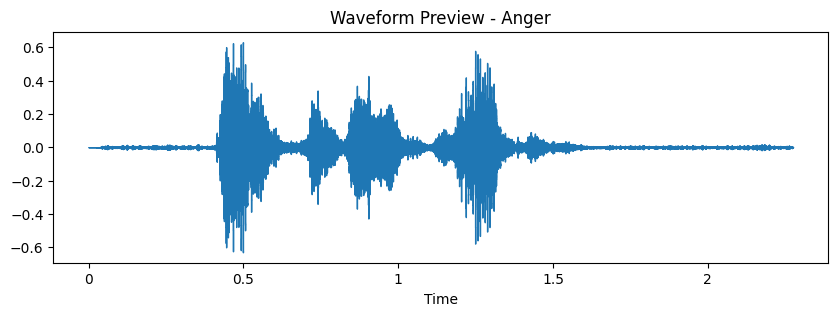

In [28]:
import librosa, librosa.display, matplotlib.pyplot as plt

path = "CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav"
y, sr = librosa.load(path, sr=None)
print("Sample rate:", sr)
print("Duration (sec):", librosa.get_duration(y=y, sr=sr))

plt.figure(figsize=(10,3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform Preview - Anger")
plt.show()


Phase 4 - Data Cleaning

In [29]:
#Check for Corrupted Files

In [30]:
def is_valid_audio(file_path):
    try:
        librosa.load(file_path, sr=None)
        return True
    except:
        return False

import glob
audio_files = glob.glob('CREMA-D/AudioWAV/*.wav')
valid_files = [f for f in audio_files if is_valid_audio(f)]
print("Valid files:", len(valid_files))


Valid files: 7442


In [31]:
y, sr = librosa.load('CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav', sr=None)
print("Loaded successfully!", sr, "Hz")


Loaded successfully! 16000 Hz


In [32]:
#Minimum Duration Filter

In [33]:
filtered_files = []
for f in valid_files:
    y, sr = librosa.load(f, sr=16000)
    if librosa.get_duration(y=y, sr=sr) > 0.5:
        filtered_files.append(f)
print("After duration filter:", len(filtered_files))


After duration filter: 7442


In [34]:
#Remove Duplicates (by file hash)

In [35]:
import hashlib

def md5(fname):
    with open(fname, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

unique, final_files = {}, []
for f in filtered_files:
    h = md5(f)
    if h not in unique:
        unique[h] = f
        final_files.append(f)
print("After removing duplicates:", len(final_files))


After removing duplicates: 7439


In [36]:
#Extract Emotion Labels

In [37]:
import pandas as pd

emotion_map = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

data = []
for f in final_files:
    code = f.split('_')[2]
    if code in emotion_map:
        data.append([f, emotion_map[code]])

df = pd.DataFrame(data, columns=['path', 'emotion'])
df.head()


path  emotion
0  CREMA-D/AudioWAV/1017_MTI_FEA_XX.wav     Fear
1  CREMA-D/AudioWAV/1010_DFA_HAP_XX.wav    Happy
2  CREMA-D/AudioWAV/1030_ITS_SAD_XX.wav      Sad
3  CREMA-D/AudioWAV/1056_ITH_DIS_XX.wav  Disgust
4  CREMA-D/AudioWAV/1076_IEO_DIS_LO.wav  Disgust

PHASE 5 — EXPLORATORY DATA ANALYSIS (EDA)

In [38]:
#Class Distribution

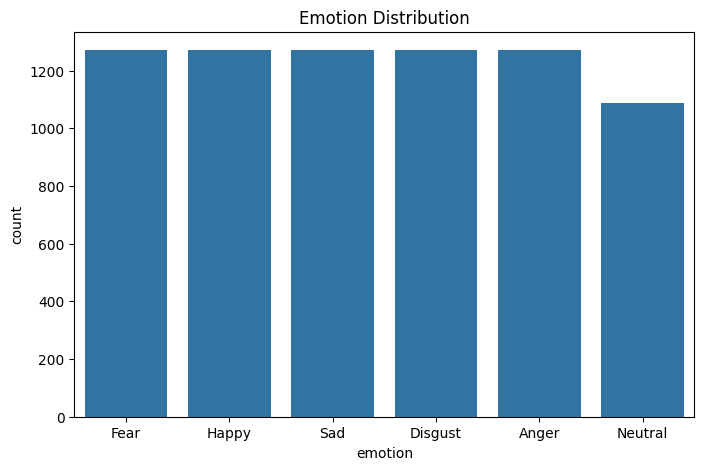

In [39]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', data=df)
plt.title("Emotion Distribution")
plt.show()


In [40]:
#Spectrogram Visualization

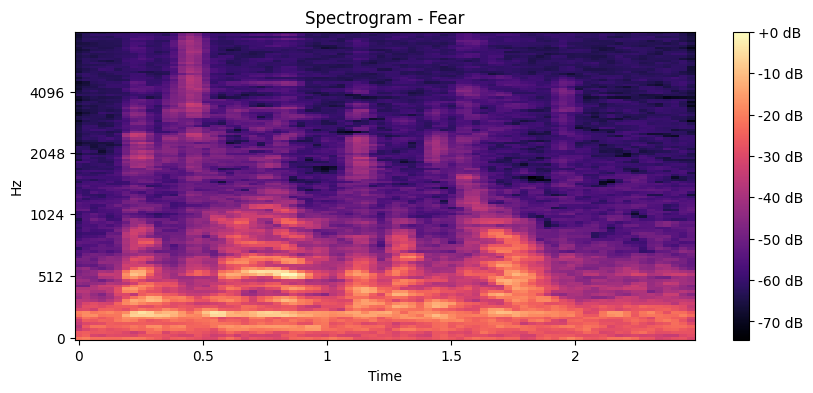

In [41]:
import numpy as np
file = df.iloc[0]['path']
y, sr = librosa.load(file, sr=16000)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10,4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram - {df.iloc[0]['emotion']}")
plt.show()


PHASE 6 — FEATURE EXTRACTION (MFCCs)

In [42]:
#Extract Features

In [43]:
from tqdm import tqdm

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

X, y_labels = [], []
for path, emotion in tqdm(zip(df['path'], df['emotion']), total=len(df)):
    features = extract_features(path)
    X.append(features)
    y_labels.append(emotion)

X = np.array(X)
y_labels = np.array(y_labels)
print(X.shape, y_labels.shape)


100%|██████████| 7439/7439 [01:26<00:00, 86.28it/s]

(7439, 40) (7439,)


In [44]:
#Save Features to Google Drive

In [45]:
np.save("/content/drive/MyDrive/SpeechEmotionRecognition/X_features.npy", X)
np.save("/content/drive/MyDrive/SpeechEmotionRecognition/y_labels.npy", y_labels)


PHASE 7 — MODEL TRAINING & EVALUATION

In [46]:
#Split Dataset

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(X_train.shape, X_test.shape)


(5951, 40) (1488, 40)


In [48]:
#Train Random Forest Model

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.44489247311827956
              precision    recall  f1-score   support

       Anger       0.56      0.66      0.61       254
     Disgust       0.39      0.33      0.36       254
        Fear       0.41      0.20      0.27       254
       Happy       0.38      0.38      0.38       254
     Neutral       0.36      0.44      0.40       218
         Sad       0.51      0.65      0.57       254

    accuracy                           0.44      1488
   macro avg       0.44      0.44      0.43      1488
weighted avg       0.44      0.44      0.43      1488



In [50]:
#Confusion Matrix

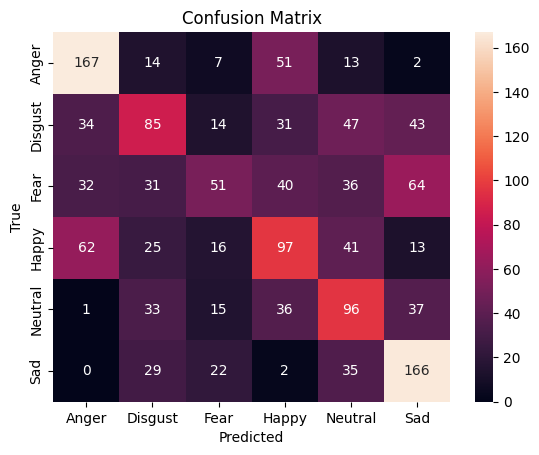

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [52]:
#Save Model to Google Drive

In [53]:
import joblib
joblib.dump(clf, "/content/drive/MyDrive/SpeechEmotionRecognition/rf_model.pkl")


['/content/drive/MyDrive/SpeechEmotionRecognition/rf_model.pkl']

PHASE 8 — TEST ON CUSTOM AUDIO FILE

1. Testing using a sample from CREMA-D

In [54]:
test_file = "CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav"


In [55]:
def predict_emotion(file_path):
    # Reuse your feature extraction function
    feature = extract_features(file_path)

    # Model prediction
    pred = clf.predict([feature])

    # Decode the numeric label back to emotion name
    return le.inverse_transform(pred)[0]


In [56]:
test_file = "CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav"
print("Predicted Emotion:", predict_emotion(test_file))


Predicted Emotion: Happy


2. Testing using a free .wav file online

In [66]:
from google.colab import files
uploaded = files.upload()


Saving 370034__honest_cactus__emotionless-monotone-request-by-lee.wav to 370034__honest_cactus__emotionless-monotone-request-by-lee.wav


In [67]:
test_file = list(uploaded.keys())[0]
print("Predicted Emotion:", predict_emotion(test_file))


Predicted Emotion: Fear


In [68]:
from IPython.display import Audio
Audio(test_file)


3. Testing using Recording my Own Voice

In [69]:
from google.colab import files
uploaded = files.upload()


Saving myVoice.wav to myVoice (1).wav


In [70]:
from IPython.display import Audio
Audio("myVoice.wav")


In [71]:
test_file = "myVoice.wav"
print("Predicted Emotion:", predict_emotion(test_file))


Predicted Emotion: Anger


In [63]:
from google.colab import files
uploaded = files.upload()


Saving Nov 4 at 8-50 PM.wav to Nov 4 at 8-50 PM (1).wav


In [64]:
from IPython.display import Audio
Audio("Nov 4 at 8-50 PM.wav")

In [65]:
test_file = "Nov 4 at 8-50 PM.wav"
print("Predicted Emotion:", predict_emotion(test_file))

Predicted Emotion: Happy


Comparative Ananlysis

In [72]:
!pip install xgboost seaborn librosa numpy pandas scikit-learn matplotlib


In [73]:
# ===========================
# Step 1: Imports and Setup
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [74]:
# ===========================
# Step 2: Train and Evaluate
# ===========================

# Make sure y_pred_rf already exists from your Random Forest model
# If not, rerun your Random Forest training before this

# ---- 1. Support Vector Machine ----
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [75]:

# ---- 2. Logistic Regression ----
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:

# ---- 3. XGBoost ----
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


y_pred_rf = y_pred

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.44489247311827956
              precision    recall  f1-score   support

       Anger       0.56      0.66      0.61       254
     Disgust       0.39      0.33      0.36       254
        Fear       0.41      0.20      0.27       254
       Happy       0.38      0.38      0.38       254
     Neutral       0.36      0.44      0.40       218
         Sad       0.51      0.65      0.57       254

    accuracy                           0.44      1488
   macro avg       0.44      0.44      0.43      1488
weighted avg       0.44      0.44      0.43      1488



In [79]:
# ---- Store results ----
models = {
    "Random Forest": (y_pred_rf, "green"),
    "SVM (RBF)": (y_pred_svm, "orange"),
    "Logistic Regression": (y_pred_lr, "blue"),
    "XGBoost": (y_pred_xgb, "purple")
}

In [80]:
# ===========================
# Step 3: Accuracy Table
# ===========================
results = []
for name, (y_pred, _) in models.items():
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy
0        Random Forest  0.444892
1            SVM (RBF)  0.421371
2  Logistic Regression  0.390457
3              XGBoost  0.473790


/tmp/ipython-input-3733129139.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")


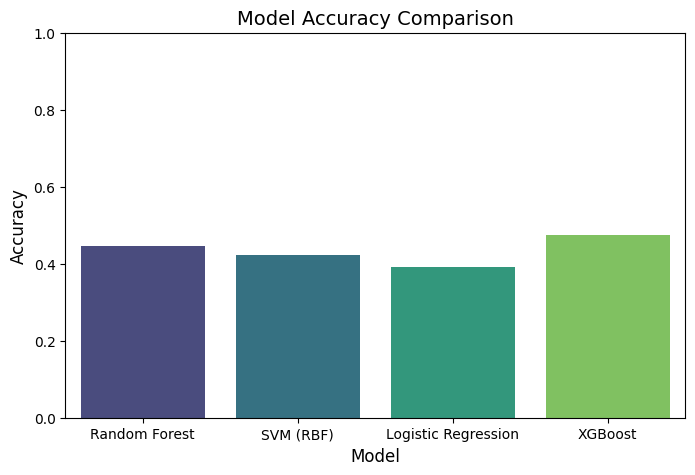

In [81]:
# ===========================
# Step 4: Bar Chart Visualization
# ===========================
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.show()


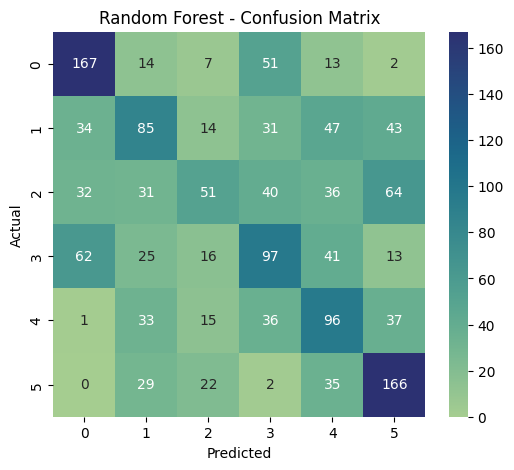

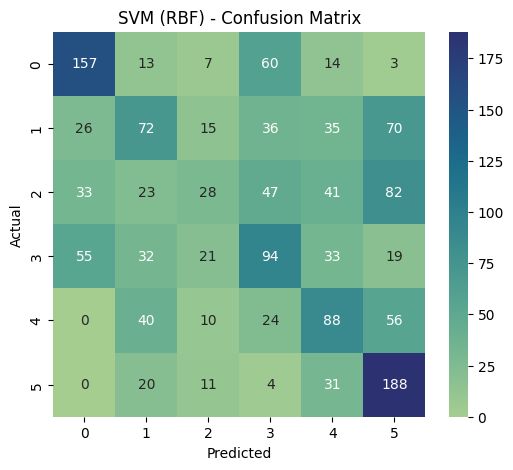

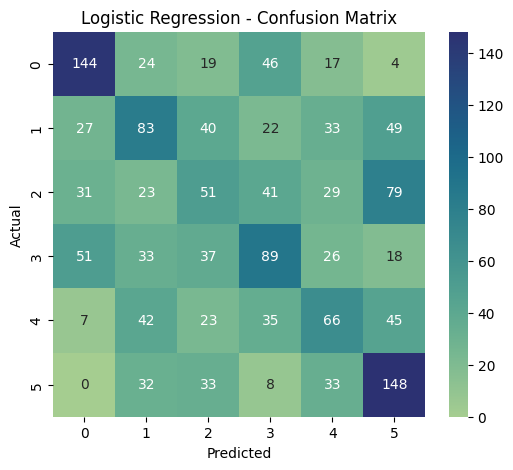

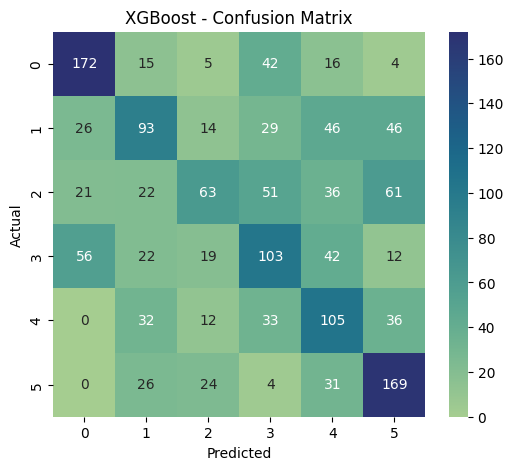

In [82]:
# ===========================
# Step 5: Confusion Matrices
# ===========================
for name, (y_pred, _) in models.items():
    plt.figure(figsize=(6,5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [83]:
# ===========================
# Step 6: Final Comparison Table
# ===========================
comparison_data = {
    "Model": ["Random Forest", "SVM (RBF)", "Logistic Regression", "XGBoost"],
    "Accuracy (%)": [
        round(accuracy_score(y_test, y_pred_rf)*100, 2),
        round(accuracy_score(y_test, y_pred_svm)*100, 2),
        round(accuracy_score(y_test, y_pred_lr)*100, 2),
        round(accuracy_score(y_test, y_pred_xgb)*100, 2)
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print("\nFinal Model Comparison:\n")
display(comparison_df)



Final Model Comparison:



Model  Accuracy (%)
0        Random Forest         44.49
1            SVM (RBF)         42.14
2  Logistic Regression         39.05
3              XGBoost         47.38